# Задача 4. Многоклассовая классификация и множественная классификация/регрессия
Шлегель АВ группа 20.Б11-мм (471)

# Датасет
В качестве набора данных рассмотрим встроенный в **sklearn** датасет с информацией о разновидностях ириса.

Признаки:
- **sepal length (cm)** - длина чашелистика,
- **sepal width (cm)** - ширина чашелистика,
- **petal length (cm)** - длина лепестка,
- **petal width (cm)** - ширина лепестка.

Целевой признак:
- **target** - вид ириса.

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()

df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                  columns=iris['feature_names'] + ['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


Пропущенных значений в данных нет, поэтому дополнительно их чистить или дополнять не требуется.
Выборка обладает количественными признаками для решения задачи классификации.
В данных с виду не наблюдается явно лишних признаков.

Однако целевой признак удобно закодировать целыми числами.

In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['target'] = encoder.fit_transform(df['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Разведочный анализ (EDA)

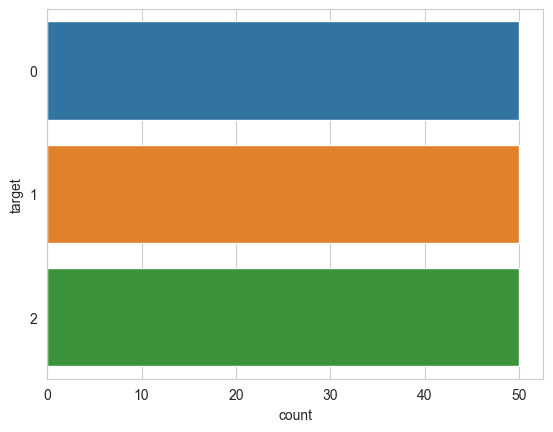

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, y="target", palette="tab10")
plt.show()

In [6]:
df.target.value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

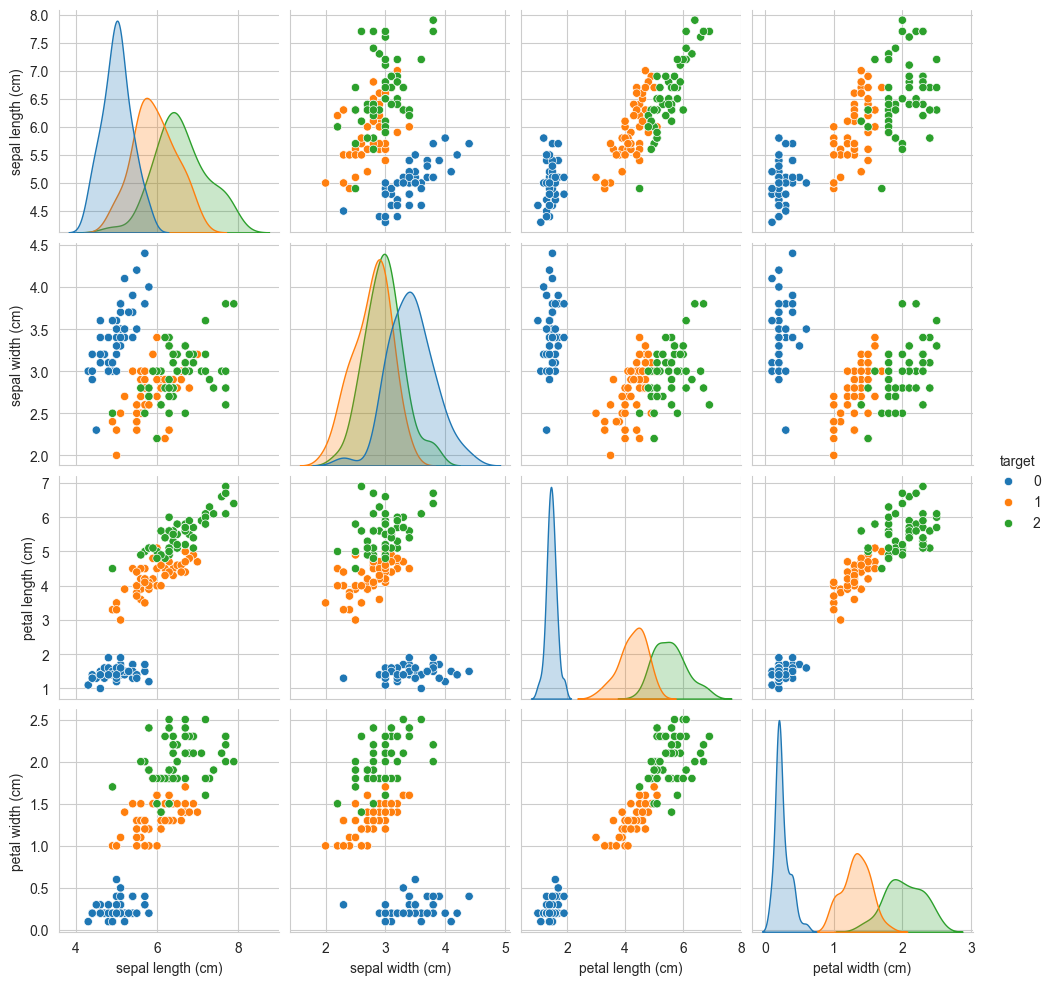

In [7]:
_ = sns.pairplot(df, hue='target', palette="tab10")

Исходя из распределений ясно, что ирис вида **0** заметно отличается по всем параметрам своего листа от двух других видов.
Остальные виды **1** и **2** имеют несколько совпадающих параметров листа, особенно **sepal length (cm)**. Поэтому данный признак лучше не учитывать для данных видов.

Интересно отдельно посмотреть на распределения каждого признака относительно целевого.

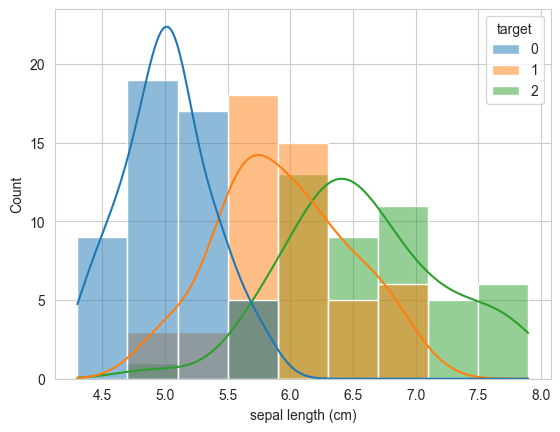

In [8]:
_ = sns.histplot(x='sepal length (cm)', hue='target', data=df, kde=True, palette='tab10')

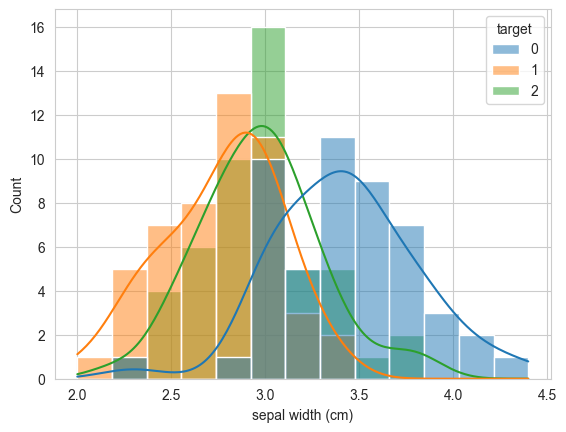

In [9]:
_ = sns.histplot(x='sepal width (cm)', hue='target', data=df, kde=True, palette='tab10')

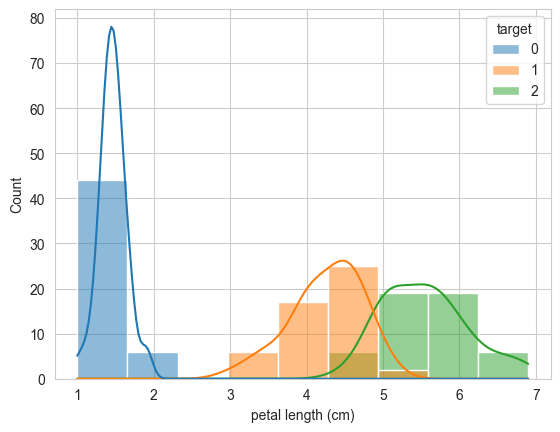

In [10]:
_ = sns.histplot(x='petal length (cm)', hue='target', data=df, kde=True, palette='tab10')

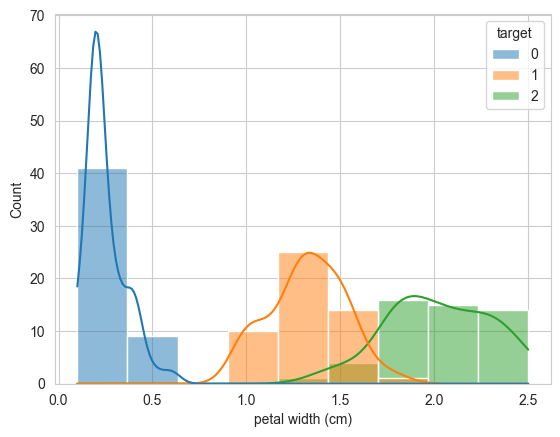

In [11]:
_ = sns.histplot(x='petal width (cm)', hue='target', data=df, kde=True, palette='tab10')

Графики показывают, что именно по признакам **petal** будет проще всего решать, какому классу принадлежит ирис.

Наконец, изучим корреляционную карту данного датасета.

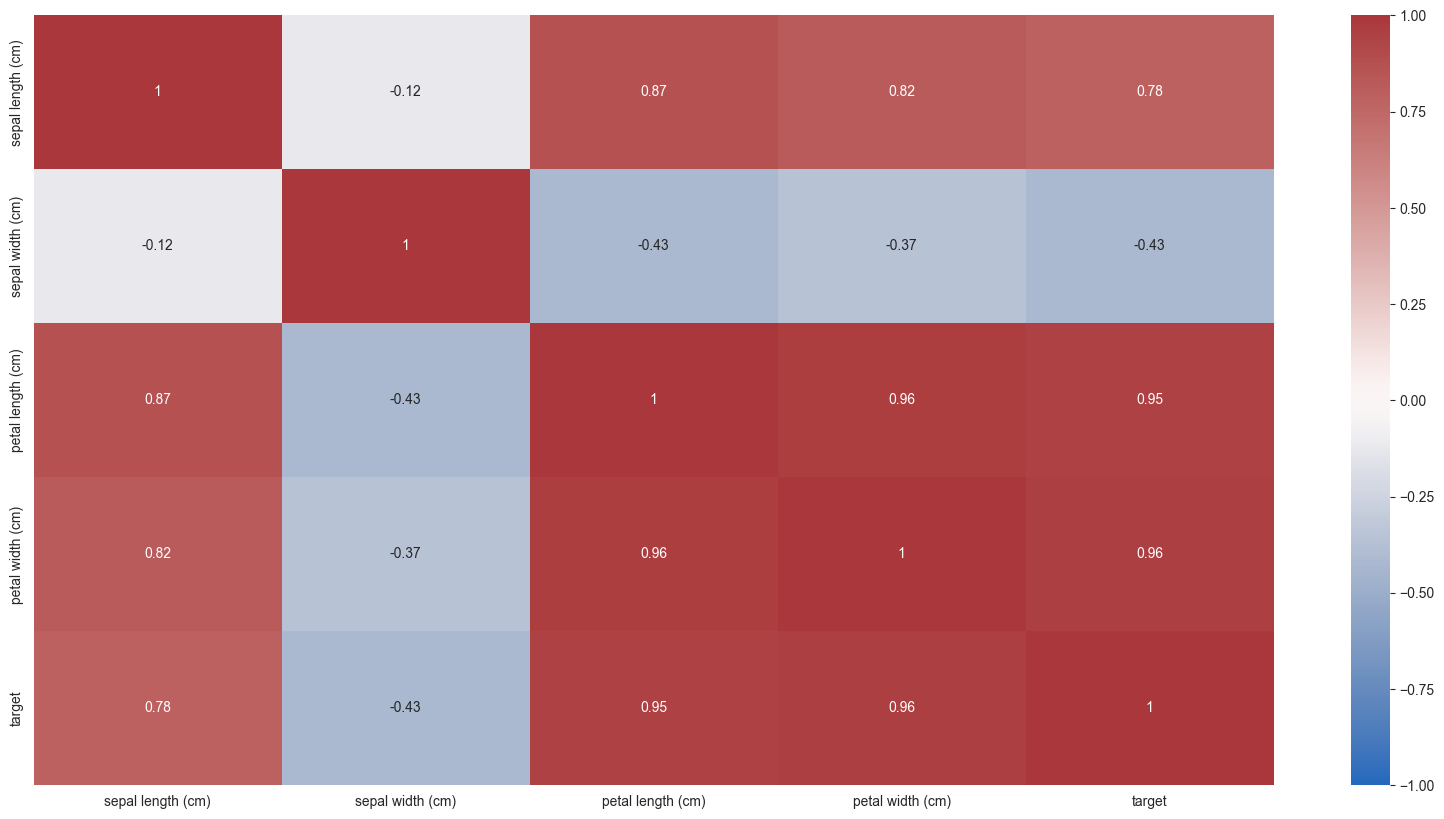

In [12]:
plt.figure(figsize=(20, 10))
_ = sns.heatmap(df.corr(), vmin=-1, annot=True, cmap="vlag")

**sepal width (cm)** имеет отрицательную корреляцию с **target**. Другие признаки имеют большую корреляцию с целевым признаком. При этом у данных признаков также наблюдается сильная корреляция между собой.

In [13]:
from sklearn.model_selection import train_test_split

x = df.drop(['target'], axis=1)
y = df['target']

## Масштабирование признаков

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

x = pd.DataFrame(scaler.transform(x), columns=x.columns)
x.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-8.171579,-4.692167,-2.897701,-3.310257
1,-8.465212,-7.341695,-2.897701,-3.310257
2,-8.758845,-6.281884,-2.930006,-3.310257
3,-8.905661,-6.811789,-2.865396,-3.310257
4,-8.318395,-4.162262,-2.897701,-3.310257


## Подбор оптимальных признаков (RFE)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [16]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifierCV

rfecv = RFECV(estimator=RidgeClassifierCV())

rfecv.fit(x_train, y_train)

selected_features = list(x_train.columns[rfecv.support_])
print("Optimal features: ", rfecv.n_features_)
print("Selected features: ", selected_features)

Optimal features:  3
Selected features:  ['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Удалим признак **sepal length (cm)**, не входящий в данный список. Как было замечено ранее, по нему сложнее всего разделить **1** и **2** виды ириса.

In [17]:
x_train = x_train[selected_features]
x_test = x_test[selected_features]

## Подбор оптимальных гиперпараметров и кросс-валидация

In [18]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(5, shuffle=True, random_state=42)

### Библиотечная реализация LogisticRegression

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_grid, cv=cv, verbose=5,
                        scoring="roc_auc_ovr", error_score="raise")

searcher = searcher.fit(x_train, y_train)

optimal_logreg_c = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...........................C=0.001;, score=0.908 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.971 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.848 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.922 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.986 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.914 total time=   0.0s
[CV 2/5] END .............................C=0.1;, score=0.987 total time=   0.0s
[CV 3/5] END .............................C=0.1;, score=0.874 total time=   0.0s
[CV 4/5] END .............................C=0.1;, score=0.987 total time=   0.0s
[CV 5/5] END .............................C=0.1;, score=1.000 total time=   0.0s
[CV 1/5] END ...............................C=1;, score=0.997 total time=   0.0s
[CV 2/5] END ...............................C=1;,

### Библиотечная реализация SVM

In [20]:
from sklearn.svm import SVC

param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(SVC(random_state=42, probability=True), param_grid=param_grid, cv=cv, verbose=5,
                        scoring="roc_auc_ovr", error_score="raise")

searcher = searcher.fit(x_train, y_train)

optimal_kernel = searcher.best_params_["kernel"]
optimal_svm_c = searcher.best_params_["C"]
optimal_gamma = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.993 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.987 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.993 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.893 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.760 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.739 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.746 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.779 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.993 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=auto, kernel=linear

### Библиотечная реализация KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
               "weights": ['distance', 'uniform']}]

searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv, verbose=5,
                        scoring="roc_auc_ovr", error_score="raise")

searcher = searcher.fit(x_train, y_train)

optimal_n_neighbors = searcher.best_params_["n_neighbors"]
optimal_weights = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.927 total time=   0.0s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.935 total time=   0.0s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.854 total time=   0.0s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.967 total time=   0.0s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=0.929 total time=   0.0s
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.927 total time=   0.0s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.935 total time=   0.0s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.854 total time=   0.0s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.967 total time=   0.0s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=0.929 total time=   0.0s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.927 total time=   0.0s
[CV 2/5] END ...n_neighbors=3, weights=distance

### Библиотечная реализация Naive Bayes

In [22]:
from sklearn.naive_bayes import GaussianNB

param_grid = [{"var_smoothing": np.logspace(0, -10, num=100)}]

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv, verbose=5,
                        scoring="roc_auc_ovr", error_score="raise")

searcher = searcher.fit(x_train, y_train)

optimal_var_smoothing = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .................var_smoothing=1.0;, score=0.905 total time=   0.0s
[CV 2/5] END .................var_smoothing=1.0;, score=0.971 total time=   0.0s
[CV 3/5] END .................var_smoothing=1.0;, score=0.856 total time=   0.0s
[CV 4/5] END .................var_smoothing=1.0;, score=0.946 total time=   0.0s
[CV 5/5] END .................var_smoothing=1.0;, score=0.993 total time=   0.0s
[CV 1/5] END ..var_smoothing=0.7924828983539173;, score=0.905 total time=   0.0s
[CV 2/5] END ..var_smoothing=0.7924828983539173;, score=0.974 total time=   0.0s
[CV 3/5] END ..var_smoothing=0.7924828983539173;, score=0.864 total time=   0.0s
[CV 4/5] END ..var_smoothing=0.7924828983539173;, score=0.956 total time=   0.0s
[CV 5/5] END ..var_smoothing=0.7924828983539173;, score=0.997 total time=   0.0s
[CV 1/5] END ..var_smoothing=0.6280291441834253;, score=0.905 total time=   0.0s
[CV 2/5] END ..var_smoothing=0.628029144183425

### Библиотечная реализация Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]

searcher = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=cv, verbose=5,
                        scoring="roc_auc_ovr", error_score="raise")

searcher = searcher.fit(x_train, y_train)

optimal_criterion = searcher.best_params_["criterion"]
optimal_splitter = searcher.best_params_["splitter"]
optimal_max_depth = searcher.best_params_["max_depth"]
optimal_min_samples_split = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["min_samples_leaf"]
optimal_max_features = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV 1/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.963 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.935 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.960 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.993 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.925 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=1.000 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_featu

## Тестирование обученных моделей

In [51]:
from sklearn.model_selection import cross_validate


def measure_time(model, X, y):
    return cross_validate(model, X, y, cv=5)["fit_time"].mean()


accuracies = []
times = []
names = []

## Стратегия **OneVsRest**

### Библиотечная реализация LogisticRegression

In [108]:
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

ovr_logreg = OneVsRestClassifier(LogisticRegression(C=optimal_logreg_c, random_state=42)).fit(x_train, y_train)
accuracy = accuracy_score(y_test, ovr_logreg.predict(x_test))
time = measure_time(ovr_logreg, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVR_LOGREG")

print(f"OVR_LOGREG accuracy {accuracy}")
print(f"OVR_LOGREG time {time}")

AxisError: axis 1 is out of bounds for array of dimension 1

### Библиотечная реализация SVM

In [53]:
ovr_svm = OneVsRestClassifier(
    SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=42, probability=True)).fit(x_train,
                                                                                                             y_train)
accuracy = accuracy_score(y_test, ovr_svm.predict(x_test))
time = measure_time(ovr_svm, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVR_SVM")

print(f"OVR_SVM accuracy {accuracy}")
print(f"OVR_SVM time {time}")

OVR_SVM accuracy 0.9111111111111111
OVR_SVM time 0.008768701553344726


### Библиотечная реализация KNN

In [54]:
ovr_knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=optimal_n_neighbors)).fit(x_train, y_train)
accuracy = accuracy_score(y_test, ovr_knn.predict(x_test))
time = measure_time(ovr_knn, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVR_KNN")

print(f"OVR_KNN accuracy {accuracy}")
print(f"OVR_KNN time {time}")

OVR_KNN accuracy 0.9555555555555556
OVR_KNN time 0.007389593124389649


### Библиотечная реализация Naive Bayes

In [55]:
ovr_nb = OneVsRestClassifier(GaussianNB(var_smoothing=optimal_var_smoothing)).fit(x_train, y_train)
accuracy = accuracy_score(y_test, ovr_nb.predict(x_test))
time = measure_time(ovr_nb, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVR_NB")

print(f"OVR_NB accuracy {accuracy}")
print(f"OVR_NB time {time}")

OVR_NB accuracy 0.9555555555555556
OVR_NB time 0.003125429153442383


### Библиотечная реализация Decision Tree

In [56]:
ovr_dt = OneVsRestClassifier(DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                                    max_features=optimal_max_features,
                                                    min_samples_leaf=optimal_min_samples_leaf,
                                                    min_samples_split=optimal_min_samples_split,
                                                    splitter=optimal_splitter, random_state=42)).fit(x_train, y_train)
accuracy = accuracy_score(y_test, ovr_dt.predict(x_test))
time = measure_time(ovr_dt, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVR_DT")

print(f"OVR_DT accuracy {accuracy}")
print(f"OVR_DT time {time}")

OVR_DT accuracy 1.0
OVR_DT time 0.006252717971801758


## Стратегия **OneVsOne**

### Библиотечная реализация LogisticRegression

In [57]:
from sklearn.multiclass import OneVsOneClassifier

ovo_logreg = OneVsOneClassifier(LogisticRegression(C=optimal_logreg_c, random_state=42)).fit(x_train, y_train)
accuracy = accuracy_score(y_test, ovo_logreg.predict(x_test))
time = measure_time(ovo_logreg, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVO_LOGREG")

print(f"OVO_LOGREG accuracy {accuracy}")
print(f"OVO_LOGREG time {time}")

OVO_LOGREG accuracy 0.9777777777777777
OVO_LOGREG time 0.009354448318481446


### Библиотечная реализация SVM

In [58]:
ovo_svm = OneVsOneClassifier(
    SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=42, probability=True)).fit(x_train,
                                                                                                             y_train)
accuracy = accuracy_score(y_test, ovo_svm.predict(x_test), multi_class='ovo')
time = measure_time(ovo_svm, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVO_SVM")

print(f"OVO_SVM accuracy {accuracy}")
print(f"OVO_SVM time {time}")

OVO_SVM accuracy 0.9777777777777777
OVO_SVM time 0.007452869415283203


### Библиотечная реализация KNN

In [59]:
ovo_knn = OneVsOneClassifier(KNeighborsClassifier(n_neighbors=optimal_n_neighbors)).fit(x_train, y_train)
accuracy = accuracy_score(y_test, ovo_knn.predict(x_test))
time = measure_time(ovo_knn, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVO_KNN")

print(f"OVO_KNN accuracy {accuracy}")
print(f"OVO_KNN time {time}")

OVO_KNN accuracy 0.9555555555555556
OVO_KNN time 0.0031291484832763673


### Библиотечная реализация Naive Bayes

In [60]:
ovo_nb = OneVsOneClassifier(GaussianNB(var_smoothing=optimal_var_smoothing)).fit(x_train, y_train)
accuracy = accuracy_score(y_test, ovo_nb.predict(x_test))
time = measure_time(ovo_nb, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVO_NB")

print(f"OVO_NB accuracy {accuracy}")
print(f"OVO_NB time {time}")

OVO_NB accuracy 0.9777777777777777
OVO_NB time 0.0005864620208740235


### Библиотечная реализация Decision Tree

In [61]:
ovo_dt = OneVsOneClassifier(DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                                   max_features=optimal_max_features,
                                                   min_samples_leaf=optimal_min_samples_leaf,
                                                   min_samples_split=optimal_min_samples_split,
                                                   splitter=optimal_splitter, random_state=42)).fit(x_train, y_train)
accuracy = accuracy_score(y_test, ovo_dt.predict(x_test))
time = measure_time(ovo_dt, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OVO_DT")

print(f"OVO_DT accuracy {accuracy}")
print(f"OVO_DT time {time}")

OVO_DT accuracy 0.9777777777777777
OVO_DT time 0.006524467468261718


## Стратегия **OutputCode**

### Библиотечная реализация LogisticRegression

In [62]:
from sklearn.multiclass import OutputCodeClassifier

oc_logreg = OutputCodeClassifier(LogisticRegression(C=optimal_logreg_c, random_state=42)).fit(x_train, y_train)
accuracy = accuracy_score(y_test, oc_logreg.predict(x_test))
time = measure_time(oc_logreg, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OC_LOGREG")

print(f"OC_LOGREG accuracy {accuracy}")
print(f"OC_LOGREG time {time}")

OC_LOGREG accuracy 1.0
OC_LOGREG time 0.012941265106201172


### Библиотечная реализация SVM

In [63]:
oc_svm = OutputCodeClassifier(
    SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=42, probability=True)).fit(x_train,
                                                                                                             y_train)
accuracy = accuracy_score(y_test, oc_svm.predict(x_test))
time = measure_time(oc_svm, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OC_SVM")

print(f"OC_SVM accuracy {accuracy}")
print(f"OC_SVM time {time}")

OC_SVM accuracy 0.7111111111111111
OC_SVM time 0.01566004753112793


### Библиотечная реализация KNN

In [64]:
oc_knn = OutputCodeClassifier(KNeighborsClassifier(n_neighbors=optimal_n_neighbors)).fit(x_train, y_train)
accuracy = accuracy_score(y_test, oc_knn.predict(x_test))
time = measure_time(oc_knn, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OC_KNN")

print(f"OC_KNN accuracy {accuracy}")
print(f"OC_KNN time {time}")

OC_KNN accuracy 0.9555555555555556
OC_KNN time 0.011481666564941406


### Библиотечная реализация Naive Bayes

In [65]:
oc_nb = OutputCodeClassifier(GaussianNB(var_smoothing=optimal_var_smoothing)).fit(x_train, y_train)
accuracy = accuracy_score(y_test, oc_nb.predict(x_test))
time = measure_time(oc_nb, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OC_NB")

print(f"OC_NB accuracy {accuracy}")
print(f"OC_NB time {time}")

OC_NB accuracy 0.9555555555555556
OC_NB time 0.014117956161499023


### Библиотечная реализация Decision Tree

In [66]:
oc_dt = OutputCodeClassifier(DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                                    max_features=optimal_max_features,
                                                    min_samples_leaf=optimal_min_samples_leaf,
                                                    min_samples_split=optimal_min_samples_split,
                                                    splitter=optimal_splitter, random_state=42)).fit(x_train, y_train)
accuracy = accuracy_score(y_test, oc_dt.predict(x_test))
time = measure_time(oc_dt, x_train, y_train)

accuracies.append(accuracy)
times.append(time)
names.append("OC_DT")

print(f"OC_DT accuracy {accuracy}")
print(f"OC_DT time {time}")

OC_DT accuracy 1.0
OC_DT time 0.012120199203491212


## Сравнение обученных моделей

### Точность

In [67]:
accuracy_df = pd.DataFrame(list(zip(names, accuracies)), columns=['Name', 'Accuracy'])

In [91]:
accuracy_logreg_df = pd.DataFrame(list(zip(names[0::5], accuracies[0::5])), columns=['Name', 'Accuracy'])
accuracy_svm_df = pd.DataFrame(list(zip(names[1::5], accuracies[1::5])), columns=['Name', 'Accuracy'])
accuracy_knn_df = pd.DataFrame(list(zip(names[2::5], accuracies[2::5])), columns=['Name', 'Accuracy'])
accuracy_nb_df = pd.DataFrame(list(zip(names[3::5], accuracies[3::5])), columns=['Name', 'Accuracy'])
accuracy_dt_df = pd.DataFrame(list(zip(names[4::5], accuracies[4::5])), columns=['Name', 'Accuracy'])

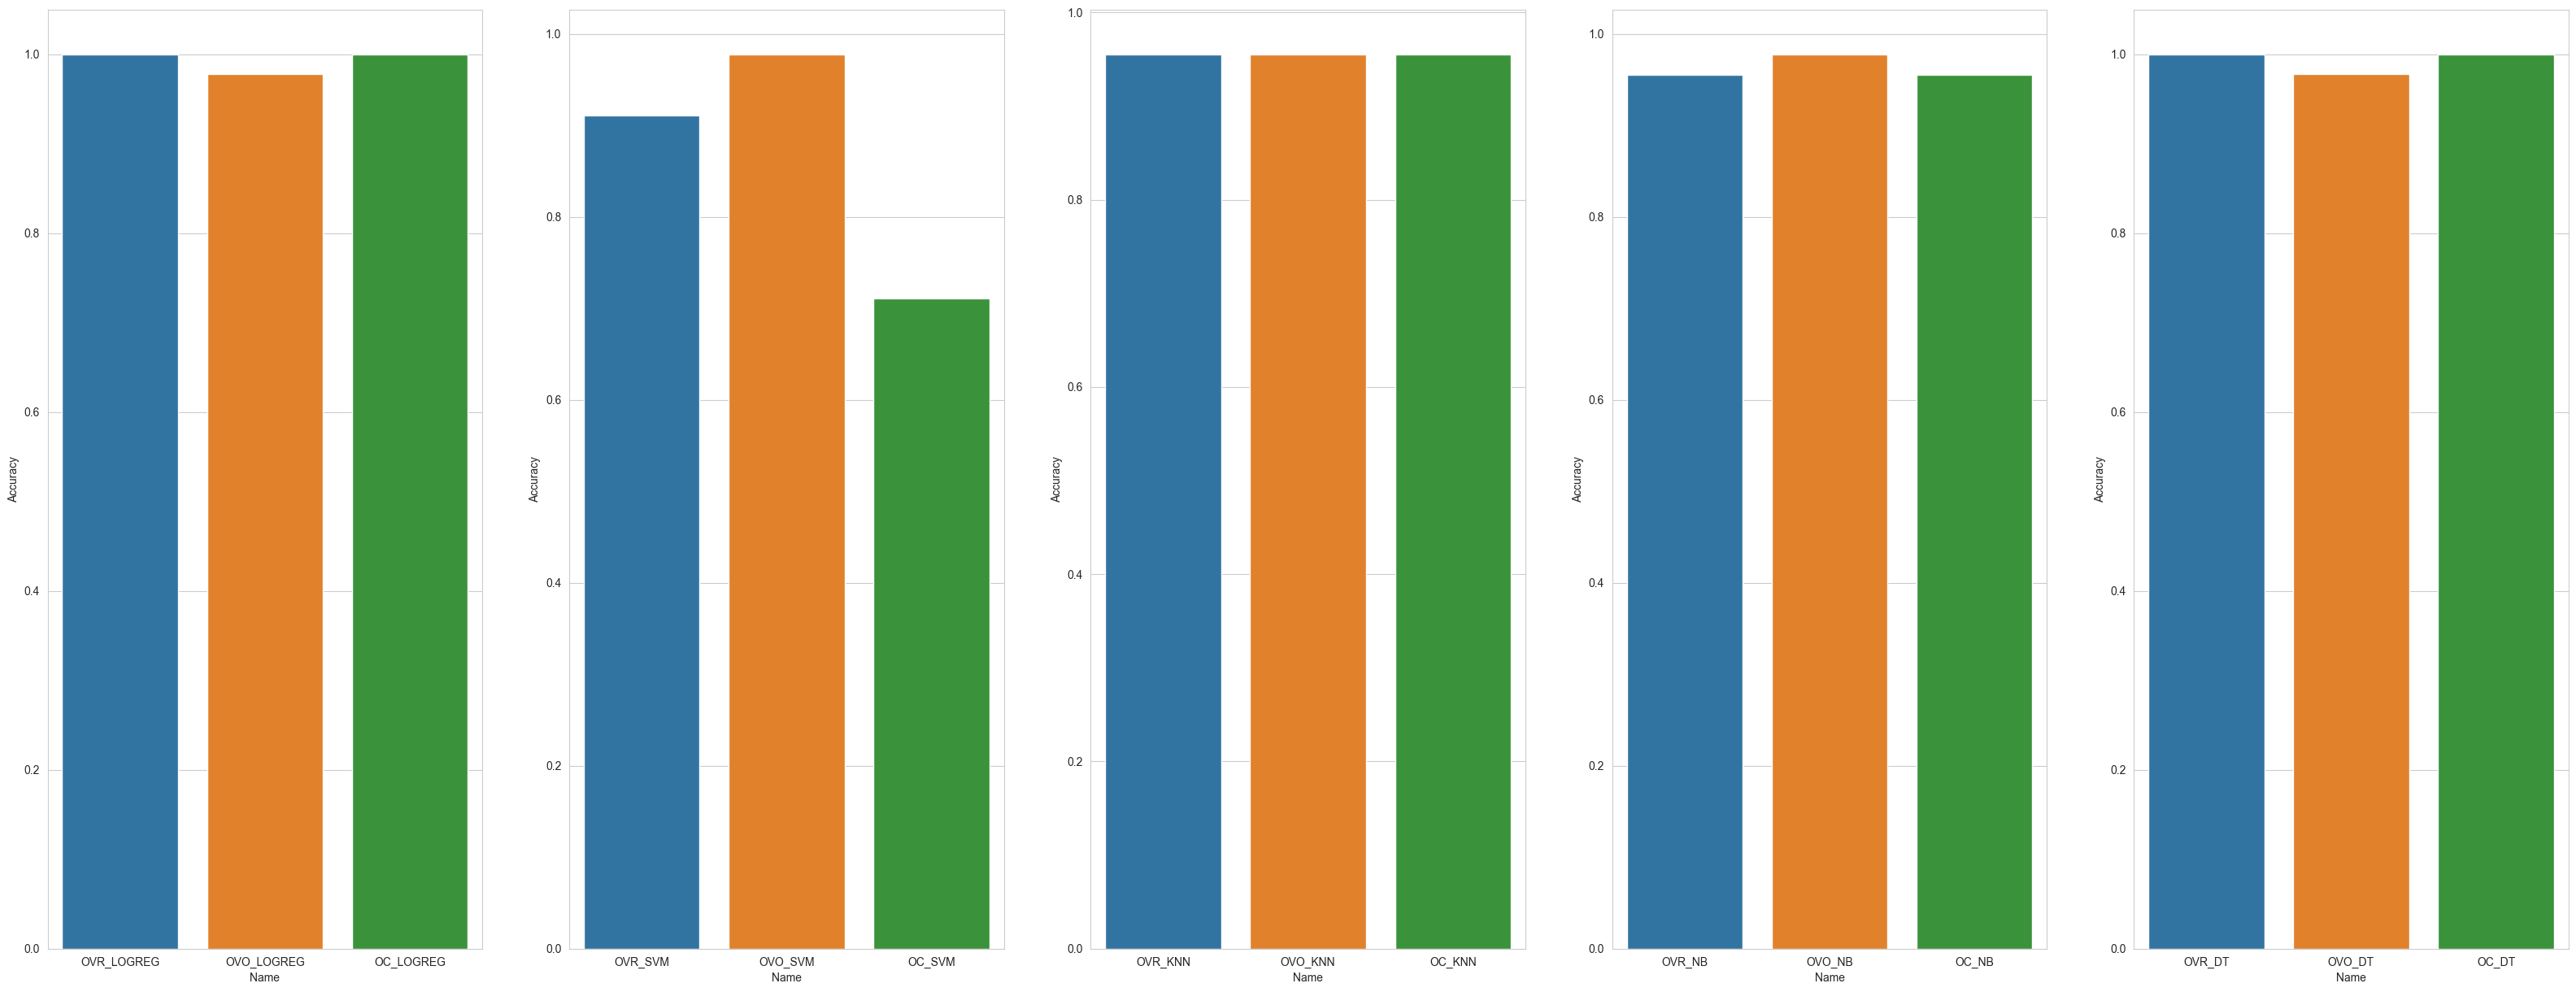

In [109]:
fig, axs = plt.subplots(ncols=5, figsize=(40, 15))
sns.barplot(accuracy_logreg_df, x='Name', y='Accuracy', palette="tab10", ax=axs[0])
sns.barplot(accuracy_svm_df, x='Name', y='Accuracy', palette="tab10", ax=axs[1])
sns.barplot(accuracy_knn_df, x='Name', y='Accuracy', palette="tab10", ax=axs[2])
sns.barplot(accuracy_nb_df, x='Name', y='Accuracy', palette="tab10", ax=axs[3])
sns.barplot(accuracy_dt_df, x='Name', y='Accuracy', palette="tab10", ax=axs[4])
plt.show()

### Время

In [98]:
time_logreg_df = pd.DataFrame(list(zip(names[0::5], times[0::5])), columns=['Name', 'Time'])
time_svm_df = pd.DataFrame(list(zip(names[1::5], times[1::5])), columns=['Name', 'Time'])
time_knn_df = pd.DataFrame(list(zip(names[2::5], times[2::5])), columns=['Name', 'Time'])
time_nb_df = pd.DataFrame(list(zip(names[3::5], times[3::5])), columns=['Name', 'Time'])
time_dt_df = pd.DataFrame(list(zip(names[4::5], times[4::5])), columns=['Name', 'Time'])

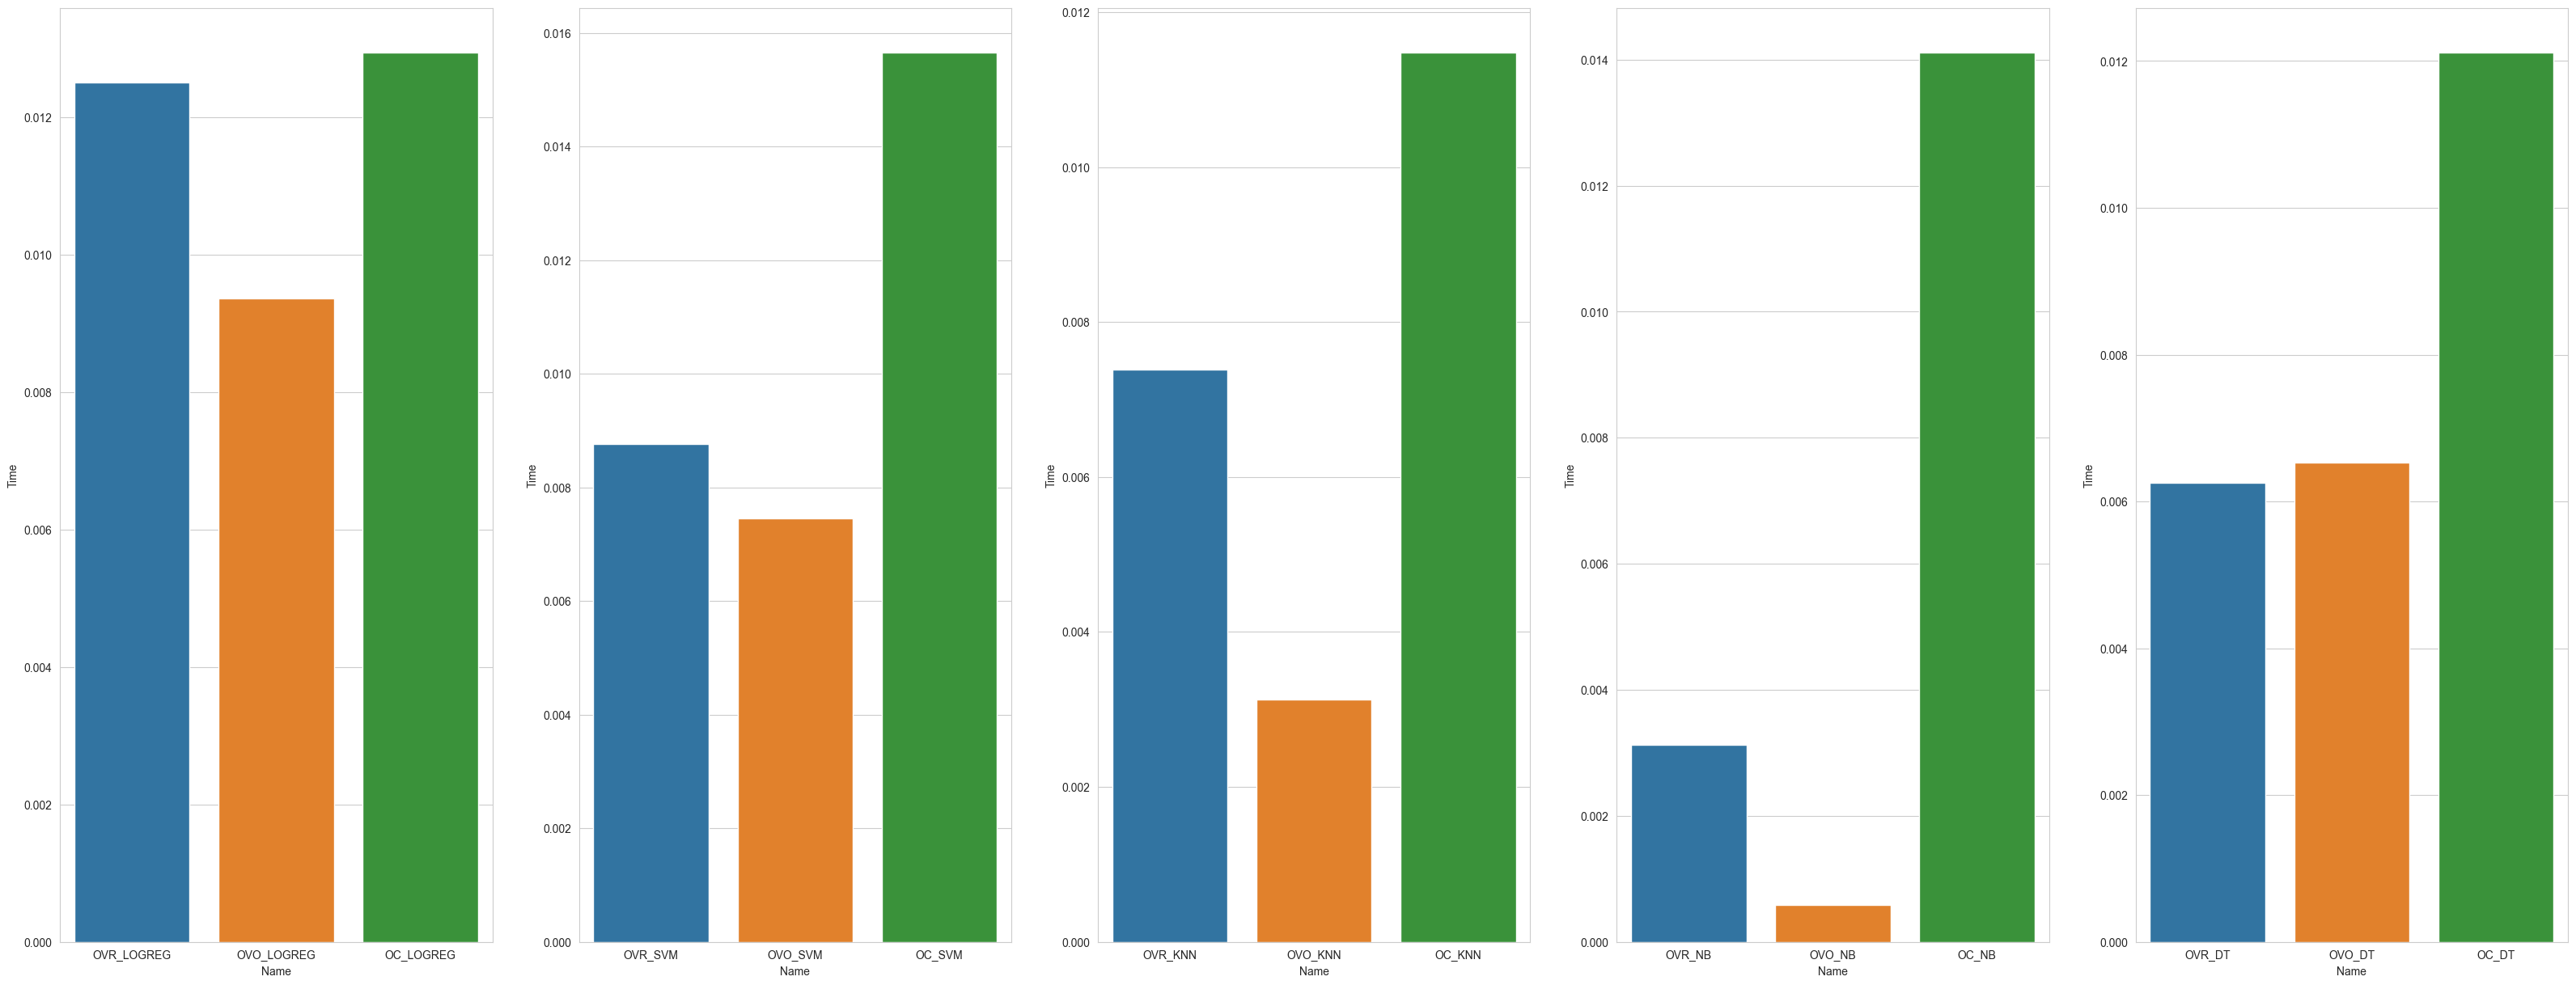

In [106]:
fig, axs = plt.subplots(ncols=5, figsize=(40, 15))
sns.barplot(time_logreg_df, x='Name', y='Time', palette="tab10", ax=axs[0])
sns.barplot(time_svm_df, x='Name', y='Time', palette="tab10", ax=axs[1])
sns.barplot(time_knn_df, x='Name', y='Time', palette="tab10", ax=axs[2])
sns.barplot(time_nb_df, x='Name', y='Time', palette="tab10", ax=axs[3])
sns.barplot(time_dt_df, x='Name', y='Time', palette="tab10", ax=axs[4])
plt.show()

## Выводы об обученных моделях датасета

Все стратегии в большинстве случаев показали высокую точность.
Наименьшую точность среди всех моделей показала стратегия **OutputCode**.
Наименьшее время исполнения среди всех моделей показала стратегия **OneVsOne**.
Наибольшее время исполнения среди всех моделей показала стратегия **OutputCode**.
Самая долгая и менее точная модель оказалась **Линейная SVM**.